# Feature Importance Analysis

本notebook旨在对生成NN3，Lightgbm和RF模型进行特征重要性分析（Feature Importance），对应的代码文件请相对应的查看NN3，Lightgbm及RF。

# Package

In [56]:
#数据读取
import os
import pyarrow.feather as feather

#数据处理
import pandas as pd
import numpy as np

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

#超参优化
import optuna

#进程展示
from tqdm import tqdm

#存贮模型
import pickle

#作图
import matplotlib.pyplot as plt 

# 绘制特征重要性 （NN3，Lightgbm，RF）

- 直接对tensorflow.keras框架搭建的nn模型进行feature Importance analysis无法对应到原dataframe数据的变量名，故需要首先将训练使用数据集的列名（变量名）绑定在feature Importance 的权重上：  

```
nn_feature_importance = pd.DataFrame({'feature': nn_feature_names[nonzero_idx], 'importance': nn_mean_weights[nonzero_idx]})  
```
-  因为不同模型计算feature Importance的方式不同，对应数据的量级也会不同。为了绘制结果的美观性，我们给神经网络的feature Importance所有数值*4000，RandomForest的fetaure Importance所有数值*10  
-  注意：下图仅展示了每个模型重要性排名前十的因子（feature/characteristics/variable）

In [43]:

"""
读入并处理数据（同NN3），以获得NN3 feature importance 分析需要的对应数据的列名
"""

#导入数据
with open('/home/mw/input/stock3636/chars60_rank_imputed.feather', 'rb') as f:
    data = feather.read_feather(f)
data['date'] = data['date'].astype('datetime64')

# 滞后代码
#我们的预测变量为下一期的股票收益率，需将下一期的股票收益率挪至本期
data['year_month'] = pd.to_datetime(data['date']).dt.to_period('M')
data['ret_fut'] = data.groupby('permno')['ret'].shift(-1)
data = data.dropna(axis=0,subset=['ret_fut']) #删除有空缺值的行

data.set_index('date', inplace=True)

# 缺失值处理
## 查看缺失值--没有缺失值
print('Missing data: {} items\n'.format(len(data[data.isna().any(1)])), data[data.isna().any(1)]) # 看一下缺失值是哪些行

#删除分类变量--embedding后约等于没有作用且速度慢
s = (data.dtypes == 'int64')
object_cols = list(s[s].index)# 移除含有类别变量的列
# 移除数据集含有类别变量的列
data = data.drop(object_cols, axis=1)

#删除影响数据分析的变量
data = data.drop(['rank_mom36m','rank_mom60m','exchcd','shrcd','lag_me'],axis=1)
data = data.drop(['ret_fut','year_month'], axis=1)


<Figure size 1000x600 with 1 Axes>
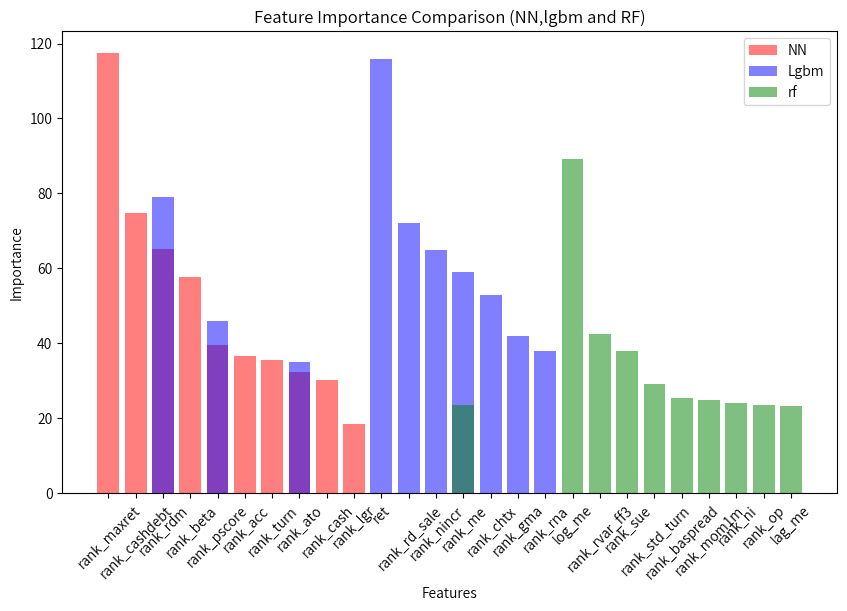

In [74]:
"""
Feature Importance Analysis
"""

"""
Part I： Feature Importance of NN3
"""

# 读取模型
with open('/home/mw/project/Model/NN3.pkl', 'rb') as f:
    nn_model = pickle.load(f)

# 获取特征名称
nn_feature_names  = data.columns[:-1]

# 获取输入层权重
nn_input_layer = nn_model.layers[0]
nn_weights = nn_input_layer.get_weights()[0]

# 获取特征重要性
nn_mean_weights = nn_weights.mean(axis=0)*4000   #为作图美观乘以4000
nn_nonzero_idx = nn_mean_weights.nonzero()[0]    #因为feature Importance == 0时不展示变量，所以我们仅需要 feature Importace != 0 的列名
nn_feature_importance = pd.DataFrame({'feature': nn_feature_names[nonzero_idx], 'importance': nn_mean_weights[nonzero_idx]})
nn_feature_importance = nn_feature_importance.sort_values(by='importance', ascending=False).head(10) #选取重要性排名前十的进行展示

"""
Part II： Feature Importance of Lightgbm
"""

# 读取模型
with open('/home/mw/project/Model/lightgbm.pkl', 'rb') as f:
    lgbm_model = pickle.load(f)

# 获取特征重要性
lgbm_feature_importance = pd.DataFrame({'feature': lgbm_model.booster_.feature_name(), 'importance': lgbm_model.feature_importances_})
lgbm_feature_importance = lgbm_feature_importance.sort_values(by='importance', ascending=False).head(10) #选取重要性排名前十的进行展示


"""
Part III： Feature Importance of RF
"""

with open('/home/mw/project/Model/RF.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# 获取feature importance信息
rf_importance = rf_model.get_booster().get_score(importance_type='gain')
rf_importance = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)

# 提取特征名称和重要性得分
rf_features_names = [x[0] for x in rf_importance]
rf_importance = [x[1]*10 for x in rf_importance] #为作图美观乘以10
rf_feature_importance = pd.DataFrame({'feature': rf_features_names, 'importance': rf_importance})
rf_feature_importance = rf_feature_importance.sort_values(by='importance', ascending=False).head(10)


"""
绘图：将不同模型的Feature Importance 绘制在同一张图上
"""

# 绘制特征重要性图像
plt.figure(figsize=(10, 6))
plt.bar(nn_feature_importance['feature'], nn_feature_importance['importance'], alpha=0.5, color='r', label='NN')
plt.bar(lgbm_feature_importance['feature'], lgbm_feature_importance['importance'], alpha=0.5, color='b', label='Lgbm')
plt.bar(rf_feature_importance['feature'], rf_feature_importance['importance'], alpha=0.5, color='g', label='rf')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Comparison (NN,lgbm and RF)')
plt.legend()
plt.show()
